# The goal is to fit one pic with parts of another pic

The plan:

* Overfit one pic, to create a brush that essentially encodes it
* Directly optimize another (2nd) pic by combining brushes trained on the 1st pic

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from IPython.display import display
import tensorflow as tf
import itertools

In [3]:
print("TF version:",tf.__version__)
print(f"N GPUs available: {len(tf.config.list_physical_devices('GPU'))}")

TF version: 2.2.0
N GPUs available: 1


../../images/pics-in/uzor1.jpg


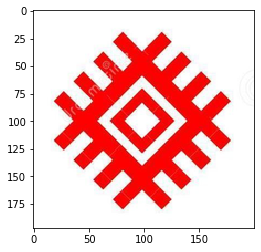

In [160]:
def loadImage(fileName, targetSize=(100,200)):
    '''
    Read and transform an image.
    
    targetSize: the img will be downsampled to this (y,x). The smaller dimension defines the output size.
    '''

    # fileName = inFolder + "road.jpg"
    print(fileName)
    im = Image.open(fileName)

    im.thumbnail(targetSize, Image.ANTIALIAS)
    # im = im.convert('L') # 1 for BW dither; L for grayscale; LAB and HSV may be interesting for the future
    im = im.convert('RGB')
    # display(im) # Faithful representation
    return im

class holder():
    i = None
    modelName = ''
    h = None
    w = None

z = holder()
z.i = 0
#im = loadImage("../../images/pics-in/b0.jpg" , (200,400))
im = loadImage("../../images/pics-in/uzor1.jpg" , (200,200))
plt.imshow(im); # Mathy representation (grayscales get pseudocolored)

In [161]:
def image_to_data(im,z):
    y = np.array(im)
    (h,w,_) = y.shape
    y = y.reshape((h*w,3))
    _x,_y = np.meshgrid(np.array(range(w))/w, np.array(range(h))/h)
    x = np.transpose(np.vstack([_x.flatten() , _y.flatten()]))
    z.h = h
    z.w = w
    return (x,y,z)

(x,y,z) = image_to_data(im,z)

print(x.shape)
print(y.shape)

(39400, 2)
(39400, 3)


In [163]:
global_history = None # To collect loss curves

In [164]:
def build_model(z):
    z.modelName = "austere_redhook"
    nBrushes = 32 # N
    nParams = 64 # Params per brush (should be high, to keep brushes high-res)
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(nBrushes*4, activation='relu', input_shape=(2,)), # Affine (2) + param passing (4-2)
        tf.keras.layers.Reshape((nBrushes,4)),
        tf.keras.layers.Conv1D(nParams, 1, activation='relu'),
        tf.keras.layers.Conv1D(nParams, 1, activation='relu'),
        tf.keras.layers.LayerNormalization(), # This one makes quite the difference!
        tf.keras.layers.Conv1D(3, 1, activation='relu'), # Output layer for the convolutional part: RGB
        tf.keras.layers.Permute((2,1)), # unorthodox use of pooling here: not in space, but across filters
        tf.keras.layers.MaxPooling1D(pool_size = (nBrushes),data_format='channels_first'), # pick one brush
        tf.keras.layers.Reshape((3,))
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mse'])
    
    return (model,z)

(model,z) = build_model(z)
model.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 128)               384       
_________________________________________________________________
reshape_75 (Reshape)         (None, 32, 4)             0         
_________________________________________________________________
conv1d_112 (Conv1D)          (None, 32, 64)            320       
_________________________________________________________________
conv1d_113 (Conv1D)          (None, 32, 64)            4160      
_________________________________________________________________
layer_normalization_13 (Laye (None, 32, 64)            128       
_________________________________________________________________
conv1d_114 (Conv1D)          (None, 32, 3)             195       
_________________________________________________________________
permute_37 (Permute)         (None, 3, 32)           


....................................................................................................

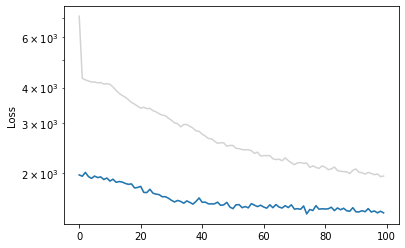

In [167]:
# Train the model:

class PrintDot(tf.keras.callbacks.Callback): # Called after each epoch
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
        
history = model.fit(x, y, epochs=100, batch_size=32, verbose=0, callbacks=[PrintDot()], shuffle=True)
# 32 seems optimal: fast (fits GPU?), and doesn't ruin the performance.

if global_history is None:
    global_history = np.array(history.history['loss'])
else:
    global_history = np.vstack((global_history, history.history['loss']))

ax = plt.axes()
ax.plot(global_history.T, '-', color='lightgray')
ax.plot(history.history['loss'])
ax.set_yscale('log')
plt.ylabel('Loss');

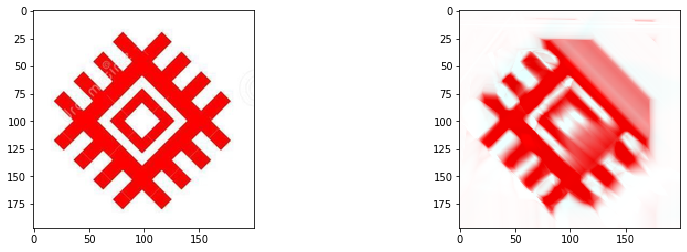

In [170]:
# This part is for visual troubleshooting; 
# the rest of modeling below doesn't depend on this cell.

y_new = model.predict(x)
y_new = np.minimum(255,np.maximum(0,y_new))/255
#y_new = (y_new-np.min(y_new))/(np.max(y_new)-np.min(y_new))

%matplotlib inline
fig, axs = plt.subplots(1,2);
fig.set_figwidth(14,5);
axs[0].imshow(y.reshape((z.h,z.w,3)));
axs[1].imshow(y_new.reshape((z.h,z.w,3)));

In [8]:
# Freeze all layers except the very first one

def turn_to_brush(model, ncopies=64):
    """Use pre-trained model as a brush by freezing its layers, and feeding in
    NCOPIES of affine transforms instead.
    
    NOT FINISHED."""
    
    model2 = tf.keras.Sequential()
    #model2.add(tf.keras.layers.Dense(ncopies*2, activation='linear', input_shape=(2,))) # Affine transforms
    model2.add(tf.keras.layers.Reshape((nBrushes,2))) # Prep for conv layers
    for layer in model.layers[2:]: # Copy all other layers 
        model2.add(layer)
    for layer in model2.layers[2:]: # Now make all layers except the first one  untrainable
        layer.trainable = False
    return _compile_model(model2)

def freezeModel(model, trainable=False):
    if trainable:
        print('Thawing convolutional layers')
    else:
        print('Freezing convolutional layers')
    i = 0
    for layer in model.layers:
        if i>0:
            layer.trainable = trainable
        i += 1

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])
    return model

model2 = turn_to_brush(model)
model2.summary()

In [168]:
def generateIm(x, y, model, z, upsample_coeff=6):
    hb = z.h*upsample_coeff
    wb = z.w*upsample_coeff
    _x,_y = np.meshgrid(np.array(range(wb))/wb, 
                        np.array(range(hb))/hb)
    xbig = np.transpose(np.vstack([_x.flatten() , _y.flatten()]))
    y_big = model.predict(xbig)
    y_big = np.minimum(255,np.maximum(0,y_big))/255
    y_big = y_big.reshape((hb,wb,3))
    y_big.shape

    img = Image.fromarray(np.uint8(255*y_big),"RGB") # Without this weird uint8 type-casting, doesn't work
    return img

# im2 = generateIm(x, y, model, z)
#display(im2)

In [11]:
def saveIm(im,z):
    outFolder = '../../images/pics-out/'
    outFileName = outFolder + "pic_%s_%d.jpg" % (z.modelName,z.i)
    print("Saving:",outFileName)
    im.save(outFileName,"jpeg")
            
# saveIm(im2,z)

## Approximate another image

Plan for the future: abstract, so that I could order n epochs on each pic. Then train (curriculum) with a suboptimal number of epochs (50?) on a series of increasigly fancy abstract pics (curriculum :) . Then abstract "freeze" command, and go through fitting normal pics.

In [ ]:
for i in range(2,11):
    z.i = i
    targetSize = (100,200)
    nEpochs = 500        
    try:
        im = loadImage(z.i, targetSize)
    except: # If it couldn't load the pic, give up
        print('Problem with loading file') 
        break
    (x,y,z) = image_to_data(im,z)       
    history = model.fit(x,y,epochs=nEpochs,batch_size=32,verbose=0,callbacks=[PrintDot()],shuffle=True)
    im2 = generateIm(x,y,model,z)
    saveIm(im2,z)